In [1]:
!curl -L https://www.dropbox.com/s/rndzndlgpw3coiq/kaggle-download.zip -o kaggle-download.zip
!unzip kaggle-download.zip -d kaggle_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     57      0 --:--:-- --:--:-- --:--:--    57
100   340  100   340    0     0    478      0 --:--:-- --:--:-- --:--:--     0
100   534    0   534    0     0    425      0 --:--:--  0:00:01 --:--:--   425
 41  515M   41  212M    0     0  46.1M      0  0:00:11  0:00:04  0:00:07 70.7M^C
Archive:  kaggle-download.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of kaggle-download.zip or
        kaggle-download.zip.zip, and cannot find kaggle-download.zip.ZIP, period.


In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Processing data

In [7]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle_data/train.csv")

In [8]:
df_taxi_data = pd.read_csv("kaggle_data/metaData_taxistandsID_name_GPSlocation.csv")
# The following code normalizes longitudes and latitudes.
# df_taxi_data["Longitude"] = (df_taxi_data["Longitude"] - df_taxi_data["Longitude"].mean()) / df_taxi_data["Longitude"].std()
# df_taxi_data["Latitude"] = (df_taxi_data["Latitude"] - df_taxi_data["Latitude"].mean()) / df_taxi_data["Latitude"].std()

In [68]:
from datetime import datetime
import math

class ModelDataset(Dataset):
    def __init__(self, mode, raw_data):
        """
        The __init__ function is run once when instantiating the Dataset object
        """
        assert mode in ['train', 'valid']
        train_len = int(len(raw_data[0]) * 0.8)
        if mode == "train":
            self.images = raw_data[0][:train_len].float()
            self.labels = raw_data[1][:train_len].float()
            self.num_samples = len(self.labels)
        else:
            self.images = raw_data[0][train_len:].float()
            self.labels = raw_data[1][train_len:].float()
            self.num_samples = len(self.labels)
            
    def __len__(self):
        """
        The __len__ function returns the number of samples in our dataset.
        """
        return self.num_samples
    
    def __getitem__(self, index):
        """
        The __getitem__ function loads and returns a sample from the dataset at the given index
        """
        image, label = self.images[index], self.labels[index]    
        return image, label
    
input_dim = 0
latlong = [[], []]
def process_data_row(row):
    def parse_time(x):
      # We are using python's builtin datetime library
      # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

      # Each x is essentially a 1 row, 1 column pandas Series
      dt = datetime.fromtimestamp(x["TIMESTAMP"])
      return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

    def get_lat_long():
        if math.isnan(row["ORIGIN_STAND"]):
            return [0, 0]
        taxi_row = df_taxi_data.iloc[int(row["ORIGIN_STAND"]) - 1]
        latlong[0].append(float(taxi_row["Latitude"]))
        latlong[1].append(float(taxi_row["Longitude"]))
        return [float(taxi_row["Latitude"]), float(taxi_row["Longitude"])]

    year, month, day, hour, weekday = parse_time(row)
    data = []
    scalars = [1]
    options = ["A", "B", "C"]
    scalars.extend([float(row["CALL_TYPE"] == val) for val in options])
    scalars.extend([float(row["DAY_TYPE"] == val) for val in options])
    
    for scalar in scalars:
        data.append(scalar)
        data.append(scalar * year)
        data.append(scalar * month)
        data.append(scalar * day)
        data.append(scalar * hour)
        data.append(scalar * weekday)
    
    data.extend(get_lat_long())
    return data
    

def process_dataset(df):
    global input_dim
    
    # Over every single 
    def polyline_to_trip_duration(polyline):
      return max(polyline.count("[") - 2, 0) * 15

    # This code creates a new column, "LEN", in our dataframe. The value is
    # the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
    df["LEN"] = df["POLYLINE"].apply(polyline_to_trip_duration)
    
    raw_train = [[],[]]
    
    for index, row in df.iterrows():
        if not row["MISSING_DATA"]:
            data = process_data_row(row)
            raw_train[0].append(data)
            raw_train[1].append(row["LEN"])
            input_dim = len(data)
    print(raw_train[0][0])
    raw_train[0] = torch.tensor(raw_train[0]).to(device)
    raw_train[1] = torch.tensor(raw_train[1]).to(device)
    
    return raw_train

raw_train = process_dataset(df_tr)

[1, 2013, 7, 1, 0, 0, 0.01, 20.13, 0.07, 0.01, 0.0, 0.0, 0.01, 20.13, 0.07, 0.01, 0.0, 0.0, 1.01, 2033.13, 7.07, 1.01, 0.0, 0.0, 1.01, 2033.13, 7.07, 1.01, 0.0, 0.0, 0.01, 20.13, 0.07, 0.01, 0.0, 0.0, 0.01, 20.13, 0.07, 0.01, 0.0, 0.0, 0.01, 0.01]


In [ ]:
# Data visualization of all trip times
plt.hist(raw_train[1].tolist(), bins=50, range=(0, 5000), linewidth=1, edgecolor='black')
plt.xlabel('Taxi Trip Time')
plt.ylabel('Frequency')
plt.show()

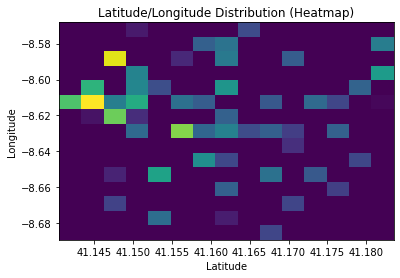

In [30]:
# Heatmap visualization of trip start points
import matplotlib.colors as mcolors
plt.hist2d(latlong[0], latlong[1], bins=15, norm=mcolors.PowerNorm(0.5))
plt.title('Latitude/Longitude Distribution (Heatmap)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [41]:
batch_size = 128

mnist_train = ModelDataset(mode='train', raw_data = raw_train)
mnist_valid = ModelDataset(mode='valid', raw_data = raw_train)
    
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle = True)

In [42]:
# Model training

In [69]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__() # Refers to the fact that this is a subclass of nn.Module and is inheriting all methods
        """
        the __init__() method that defines the layers and other components
        """ 
        self.model = torch.nn.Sequential( #an ordered container of modules
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )   

        # you can also do
        # self.layer1 = nn.Linear(input_dim, hidden_dim)
        # self.layer2 = nn.Linear(input_dim, hidden_dim)
        # ...
        # self.relu = nn.ReLU()
        
    def forward(self, x): #You never have to call model.forward(x)
        """
        the forward function is where computatioin gets done
        """
        x = x.reshape(x.shape[0], -1)
        
        out = self.model(x)    

        # if you defined each layers, maybe you need to do something like:
        # x = self.layer1(x)
        # x = self.relu(x)
        # x = self.layer2(x)
        # x = self.relu(x)

        return out

In [70]:
model = MLP(input_dim=input_dim, hidden_dim=256).to(device)

In [71]:
loss_function = torch.nn.L1Loss()
learning_rate = 1e-5

# All the optimizers have to be initialized with the model.parameters(). 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# there are other options, such as torch.optim.Adam, feel free to search pytorch documentation for details 

In [72]:
def train_epoch(train_loader, model, optimizer, loss_function):
    losses = []
    # get a batch of training data from the train_loader (DataLoader obj)
    for i, (x, t) in enumerate(train_loader):
        x.to(device)
        # make predictions for this batch
        y = model(x).flatten()
        
        # Compute the loss
        loss = loss_function(y, t)
        
        # Backpropagation
        # zero out the gradients so that it will not accumulate through each iteration
        optimizer.zero_grad()
        
        # Compute the gradents with the backward call (backprop)
        loss.backward()
        
        # Update weight using gradient descent 
        optimizer.step()
        
        losses.append(loss.item() / batch_size)
    return np.mean(losses)

def eval_epoch(valid_loader, model, loss_function):
    losses = []
    
    with torch.no_grad(): 
        for i, (x, t) in enumerate(valid_loader):
            x.to(device)
            # Compute prediction
            y = model(x).flatten()
            
            loss = loss_function(y, t)
            
            losses.append(loss.item() / batch_size)
            
    return np.mean(losses)

In [73]:
import copy

total_epochs = 50
train_losses, valid_losses = [], []
max_acc = 0
patience = 0
min_loss = math.inf
for epoch in range(total_epochs):
    
    model.train() # gradient tracking is on
    
    train_loss = train_epoch(train_loader, model, optimizer, loss_function)

    model.eval() # we don't need gradients on to do reporting
    
    valid_loss = eval_epoch(valid_loader, model, loss_function)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
 
    if valid_loss < min_loss:
        min_loss = valid_loss
        best_model = copy.deepcopy(model)
        
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:>0.4f}, Validation Loss: {valid_loss:>0.4f} \n")
    
    # early stop if model starts overfitting
    if epoch > 0 and valid_loss > valid_losses[epoch - 1]:
        patience += 1
    if patience >= 10:
        print('\nEarly stopping!')
        break

model = best_model

Epoch: 1, Train Loss: 4.0558, Validation Loss: 2.5412 

Epoch: 2, Train Loss: 2.5342, Validation Loss: 2.5280 

Epoch: 3, Train Loss: 2.5330, Validation Loss: 2.5407 

Epoch: 4, Train Loss: 2.5324, Validation Loss: 2.5200 

Epoch: 5, Train Loss: 2.5322, Validation Loss: 2.5251 

Epoch: 6, Train Loss: 2.5318, Validation Loss: 2.5311 

Epoch: 7, Train Loss: 2.5335, Validation Loss: 2.5395 

Epoch: 8, Train Loss: 2.5319, Validation Loss: 2.5258 

Epoch: 9, Train Loss: 2.5323, Validation Loss: 2.5276 

Epoch: 10, Train Loss: 2.5332, Validation Loss: 2.5337 

Epoch: 11, Train Loss: 2.5329, Validation Loss: 2.5285 

Epoch: 12, Train Loss: 2.5328, Validation Loss: 2.5257 

Epoch: 13, Train Loss: 2.5323, Validation Loss: 2.5251 

Epoch: 14, Train Loss: 2.5320, Validation Loss: 2.5422 

Epoch: 15, Train Loss: 2.5328, Validation Loss: 2.5319 

Epoch: 16, Train Loss: 2.5323, Validation Loss: 2.5266 

Epoch: 17, Train Loss: 2.5333, Validation Loss: 2.5242 

Epoch: 18, Train Loss: 2.5327, Validatio

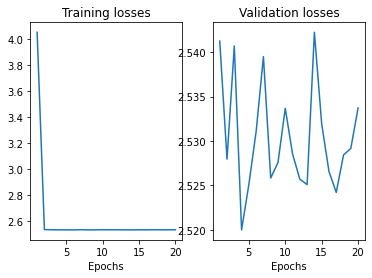

In [74]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
e = len(train_losses)
x_axis = np.arange(1, e + 1, 1)
plt.subplot(121)
plt.plot(x_axis, train_losses)
plt.title('Training losses')
plt.xlabel("Epochs")
plt.subplot(122)
plt.plot(x_axis, valid_losses)
plt.title('Validation losses')
plt.xlabel("Epochs")
plt.show()

In [75]:
# Running it on the final test set

In [76]:
# These are all of the files you are given
df_test = pd.read_csv("kaggle_data/test_public.csv")

In [77]:
titles = []
test_vals = []
for index, row in df_test.iterrows():
    titles.append(row["TRIP_ID"])
    test_vals.append(process_data_row(row))

test_vals = torch.tensor(test_vals).to(device)

In [78]:
output = model(test_vals)
output.flatten()
output = [i.item() for i in output]

df = pd.DataFrame(data={"TRIP_ID": titles, "TRAVEL_TIME": output})
df.to_csv("solution.csv", index=False)